## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import optuna

import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [3]:
df = pd.read_csv('iris.data')

In [4]:
df.columns = ['sepal length in cm', 'sepal width in cm', 'petal length in cm', 'petal width in cm', 'class']

## Data Exploration

In [5]:
df.head()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,class
0,4.9,3.0,1.4,0.2,Iris-setosa
1,4.7,3.2,1.3,0.2,Iris-setosa
2,4.6,3.1,1.5,0.2,Iris-setosa
3,5.0,3.6,1.4,0.2,Iris-setosa
4,5.4,3.9,1.7,0.4,Iris-setosa


In [6]:
df.tail()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,class
144,6.7,3.0,5.2,2.3,Iris-virginica
145,6.3,2.5,5.0,1.9,Iris-virginica
146,6.5,3.0,5.2,2.0,Iris-virginica
147,6.2,3.4,5.4,2.3,Iris-virginica
148,5.9,3.0,5.1,1.8,Iris-virginica


In [7]:
df.shape

(149, 5)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sepal length in cm  149 non-null    float64
 1   sepal width in cm   149 non-null    float64
 2   petal length in cm  149 non-null    float64
 3   petal width in cm   149 non-null    float64
 4   class               149 non-null    object 
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


There is no null values

In [9]:
df['class'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [10]:
df.duplicated().sum()

3

There is 3 duplicated rows that should be removed in preprocessing

In [11]:
df.describe()

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm
count,149.000000,149.000000,149.000000,149.000000
mean,5.848322,3.051007,3.774497,1.205369
std,0.828594,0.433499,1.759651,0.761292
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.400000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


## Preprocessing

In [12]:
df.drop_duplicates(inplace=True)

In [13]:
label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class'])

## Splitting Data

In [14]:
X = df.drop('class', axis=1)
y = df['class']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Logistic Regressor Model

In [16]:
model = LogisticRegression(random_state=0, max_iter=10)

In [17]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=10, random_state=0)

In [18]:
model.score(X_train, y_train)

0.9803921568627451

In [19]:
y_pred = model.predict(X_test)

In [20]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9545454545454546

In [21]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      0.83      0.91        12
           2       0.88      1.00      0.94        15

    accuracy                           0.95        44
   macro avg       0.96      0.94      0.95        44
weighted avg       0.96      0.95      0.95        44



## Command Line Interface

In [22]:
def predict_species(sepal_length, sepal_width, petal_length, petal_width):
    measurements = np.array([[sepal_length, sepal_width, petal_length, petal_width]])
    prediction = model.predict(measurements)
    return prediction[0]

In [23]:
species = {"Setosa": 0, "Versicolor": 1, "Virginica": 2}

In [24]:
print("Please enter the measurements of the flower (in cm).")
sepal_length = float(input("Sepal length: ")) # 6.5
sepal_width = float(input("Sepal width: ")) # 3.0
petal_length = float(input("Petal length: ")) # 5.2	
petal_width = float(input("Petal width: ")) # 2.0

pred = predict_species(sepal_length, sepal_width, petal_length, petal_width)
predicted = list(species.keys())[list(species.values()).index(pred)]
print("Predicted flower species:", predicted) # Output should be virginica

Please enter the measurements of the flower (in cm).
Predicted flower species: Virginica


## Visualization

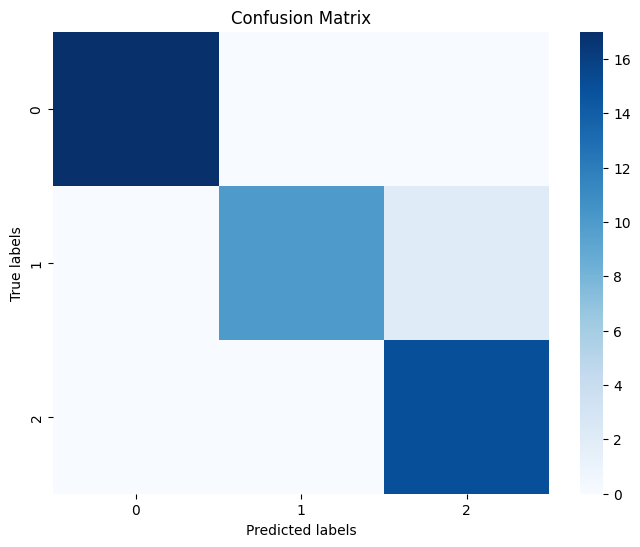

In [25]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, cmap="Blues", xticklabels=df['class'].unique(), yticklabels=df['class'].unique())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Model Tuning

In [26]:
def objective(trial):
    random_state = trial.suggest_int('random_state', 0, 45)
    max_iter = trial.suggest_int('max_iter', 100, 1000)
    
    model = LogisticRegression(random_state=42, max_iter=100)

    
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    
    return score.mean()

In [27]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=42))

[I 2024-03-25 00:52:13,207] A new study created in memory with name: no-name-e74ccc37-3706-4a02-9e59-c8b24e91c7a1


In [28]:
study.optimize(objective, n_trials=250)

[I 2024-03-25 00:52:19,890] Trial 0 finished with value: -0.02 and parameters: {'random_state': 17, 'max_iter': 956}. Best is trial 0 with value: -0.02.
[I 2024-03-25 00:52:23,070] Trial 1 finished with value: -0.02 and parameters: {'random_state': 33, 'max_iter': 639}. Best is trial 0 with value: -0.02.
[I 2024-03-25 00:52:26,258] Trial 2 finished with value: -0.02 and parameters: {'random_state': 7, 'max_iter': 240}. Best is trial 0 with value: -0.02.
[I 2024-03-25 00:52:28,310] Trial 3 finished with value: -0.02 and parameters: {'random_state': 2, 'max_iter': 880}. Best is trial 0 with value: -0.02.
[I 2024-03-25 00:52:28,372] Trial 4 finished with value: -0.02 and parameters: {'random_state': 27, 'max_iter': 737}. Best is trial 0 with value: -0.02.
[I 2024-03-25 00:52:28,433] Trial 5 finished with value: -0.02 and parameters: {'random_state': 0, 'max_iter': 973}. Best is trial 0 with value: -0.02.
[I 2024-03-25 00:52:28,482] Trial 6 finished with value: -0.02 and parameters: {'rand

In [29]:
best_model = LogisticRegression(random_state=44, max_iter=988)

In [30]:
best_model.fit(X_train, y_train)

LogisticRegression(max_iter=988, random_state=44)

In [31]:
best_model.score(X_train, y_train)

1.0

In [32]:
y_pred = best_model.predict(X_test)

In [33]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.9545454545454546

In [34]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      0.83      0.91        12
           2       0.88      1.00      0.94        15

    accuracy                           0.95        44
   macro avg       0.96      0.94      0.95        44
weighted avg       0.96      0.95      0.95        44

